<a href="https://colab.research.google.com/github/mohamedtal/PFE2021/blob/main/24_02_2021_claheTestInceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t
import cv2
import warnings
import shutil
import os
#import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout
from matplotlib import pyplot


# Sklearn utils.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# Keras.
from keras.applications.resnet50 import ResNet50
from keras.applications import DenseNet121
from keras.utils import Sequence
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

# to generate data augmentation a partir de aptos 2019 preprocessed
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import os
import cv2
%matplotlib inline

In [ ]:
# before all don't forget to use the GPU

# at first we need to get the dataset from the drive 
# pfe2021.1@gmail.com		zakimoha123
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#unzip the dataset

# for the train
!unzip /content/drive/MyDrive/dataset/DR-dataset2015.zip


In [ ]:
# for the test
!unzip /content/drive/MyDrive/dataset/DR-2019-test.zip

Clahe function

In [ ]:
def preprocessFunction(image):
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    kopya = image.copy()
    kopya = cv2.cvtColor(kopya,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thresh = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]
    kontur = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    kontur = kontur[0][0]
    kontur = kontur[:,0,:]
    x1 = tuple(kontur[kontur[:,0].argmin()])[0]
    x2 = tuple(kontur[kontur[:,0].argmax()])[0]
    y1 = tuple(kontur[kontur[:,1].argmin()])[1]
    y2 = tuple(kontur[kontur[:,1].argmax()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*5//50
    kopya2 = image.copy()
    if x2-x1>100 and y2-y1>100 :
        kopya2 = kopya2[y1+y:y2-y , x1+x:x2-x]
        kopya2 = cv2.resize(kopya2,(400,400))
    lab = cv2.cvtColor(kopya2,cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0,tileGridSize=((8,8)))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    son = cv2.cvtColor(limg,cv2.COLOR_LAB2RGB)
    med_son = cv2.medianBlur(son,3)
    arka_plan = cv2.medianBlur(son,37)
    maske = cv2.addWeighted(med_son,1,arka_plan,-1,255)
    son_img = cv2.bitwise_and(maske,med_son)
    return son_img


In [ ]:
# we need to delete samples from class 0 ( there is 25000 images, we are going to take just 7000)
import random
import os
BASE_DIR = "preprocessed/2"
NEW_DIR= "preprocessed/1"

list_dir =  os.listdir(BASE_DIR)
to_val = random.sample(list_dir, len(list_dir))
for images in to_val:
    os.rename(BASE_DIR + "/"+ images, NEW_DIR + "/" + images )

In [ ]:
# to create the preprocessed data a partir de aptos 2019

import random
import os
BASE_DIR = "DR-dataset2019-test/test/4"
NEW_DIR= "preprocessed/4"

list_dir =  os.listdir(BASE_DIR)

for images in list_dir:
    image = cv2.imread(BASE_DIR + "/"+ images)
    image = cv2.resize(image,(400,400))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    try:
        cv2.imwrite(NEW_DIR + "/" + images,cv2.cvtColor(preprocessFunction(image),cv2.COLOR_BGR2RGB))
    except Exception: 
        pass
    

In [ ]:
#!rm -r DR-dataset2019-Preprocessed/3
!ls preprocessed/0 | wc -l
!ls preprocessed/1 | wc -l
!ls preprocessed/2 | wc -l
!ls preprocessed/3 | wc -l
!ls preprocessed/4 | wc -l

1805
1369
488
ls: cannot access 'preprocessed/3': No such file or directory
0
ls: cannot access 'preprocessed/4': No such file or directory
0


In [ ]:
BASE_DIR = "preprocessed/0"
NEW_DIR= "preprocessed/0"

list_dir =  os.listdir(BASE_DIR)
from google.colab.patches import cv2_imshow
for images in list_dir:
    image = cv2.imread(BASE_DIR + "/"+ images)
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # rotation
    
    rotate=iaa.Affine(rotate=(-30, -10))
    rotated_image=rotate.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'rotated-'+images,rotated_image)

      #flip H
    flip_hr=iaa.Fliplr(p=1.0)
    flip_hr_image= flip_hr.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'fliph-'+images,flip_hr_image)

In [ ]:
BASE_DIR = "preprocessed/1"
NEW_DIR= "preprocessed/1"

list_dir =  os.listdir(BASE_DIR)
from google.colab.patches import cv2_imshow
for images in list_dir:
    image = cv2.imread(BASE_DIR + "/"+ images)
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # rotation
    
    rotate=iaa.Affine(rotate=(10, 30))
    rotated_image=rotate.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'rotated-'+images,rotated_image)

      #flip H
    flip_hr=iaa.Fliplr(p=1.0)
    flip_hr_image= flip_hr.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'fliph-'+images,flip_hr_image)



In [ ]:
BASE_DIR = "preprocessed/2"
NEW_DIR= "preprocessed/2"

list_dir =  os.listdir(BASE_DIR)
from google.colab.patches import cv2_imshow
for images in list_dir:
    image = cv2.imread(BASE_DIR + "/"+ images)
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # rotation
    
    rotate=iaa.Affine(rotate=(0, 30))
    rotated_image=rotate.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'rotated-'+images,rotated_image)

    rotate=iaa.Affine(rotate=(-30, 0))
    rotated_image=rotate.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'rotated1-'+images,rotated_image)

    #zoom
    crop = iaa.Crop(percent=(0.15, 0.3)) # crop image
    corp_image=crop.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'zoomed-'+images,corp_image)

    crop = iaa.Crop(percent=(0, 0.15)) # crop image
    corp_image=crop.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'zoomed1-'+images,corp_image)

    crop = iaa.Affine(shear=15)
    corp_image=crop.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'affine-'+images,corp_image)

    #flip H
    flip_hr=iaa.Fliplr(p=1.0)
    flip_hr_image= flip_hr.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'fliph-'+images,flip_hr_image)

    #flip V
    flip_vr=iaa.Flipud(p=1.0)
    flip_vr_image= flip_vr.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'flipv-'+images,flip_vr_image)

In [ ]:
# to generate data augmentation a partir de aptos 2019 preprocessed
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import os
import cv2
%matplotlib inline

BASE_DIR = "preprocessed/4"
NEW_DIR= "preprocessed/4"

list_dir =  os.listdir(BASE_DIR)
from google.colab.patches import cv2_imshow
for images in list_dir:
    image = cv2.imread(BASE_DIR + "/"+ images)
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # rotation
    
    rotate=iaa.Affine(rotate=(0, 30))
    rotated_image=rotate.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'rotated-'+images,rotated_image)

    rotate=iaa.Affine(rotate=(-30, 0))
    rotated_image=rotate.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'rotated1-'+images,rotated_image)

    #zoom
    crop = iaa.Crop(percent=(0.15, 0.3)) # crop image
    corp_image=crop.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'zoomed-'+images,corp_image)

    crop = iaa.Crop(percent=(0, 0.15)) # crop image
    corp_image=crop.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'zoomed1-'+images,corp_image)

    crop = iaa.Affine(shear=15)
    corp_image=crop.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'affine-'+images,corp_image)

    #flip H
    flip_hr=iaa.Fliplr(p=1.0)
    flip_hr_image= flip_hr.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'fliph-'+images,flip_hr_image)
    #flip V
    flip_vr=iaa.Flipud(p=1.0)
    flip_vr_image= flip_vr.augment_image(image)
    cv2.imwrite(NEW_DIR + "/" + 'flipv-'+images,flip_vr_image)
    

In [ ]:
#!rm -r DR-dataset2019-Preprocessed/3
!ls preprocessed/0 | wc -l
!ls preprocessed/1 | wc -l
!ls preprocessed/2 | wc -l
!ls preprocessed/3 | wc -l
!ls preprocessed/4 | wc -l

5415
4107
3904
ls: cannot access 'preprocessed/3': No such file or directory
0
ls: cannot access 'preprocessed/4': No such file or directory
0


In [ ]:
# we use the ImageDataGenerator fro : loading data into batches, pre-processing operation, data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# the train generator with data augmentation and preprocessing (rescale)
# https://xzz201920.medium.com/all-you-need-to-you-about-imagedatagenerator-in-keras-tensorflow-8fd436e4c0cd
# https://medium.com/swlh/data-augmentation-using-keras-4a852e49589f
# https://towardsdatascience.com/image-data-generators-in-keras-7c5fc6928400
# https://keras.io/api/preprocessing/image/
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

batchSize = 32

# ******** for train dataset

# with data augmentation 
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
train_datagen = ImageDataGenerator(
    #preprocessing_function = preprocessFunction,
    rescale=1./255,
    validation_split=0.15,) 

# without data augmentation
'''train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15)'''

train_generator = train_datagen.flow_from_directory(
    'preprocessed/',
    classes = ['0','1','2'],
    target_size=(400, 400),
    color_mode='rgb',
    batch_size=batchSize,
    class_mode='categorical',
    subset='training',
    shuffle=True)

# ******* for validation dataset
val_generator = train_datagen.flow_from_directory(
    'preprocessed/',
    classes = ['0','1','2'],
    class_mode='categorical',
    target_size=(400, 400),
    color_mode='rgb',
    subset='validation'
)

# ******** for test dataset
'''
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'DR-dataset2019-test/test/',
    classes = ['0','1','2','3','4'],
    target_size=(400, 400),
    class_mode='categorical',
    color_mode='rgb',
    batch_size = batchSize,
    shuffle = False)'''

Found 11413 images belonging to 3 classes.
Found 2013 images belonging to 3 classes.


"\ntest_datagen = ImageDataGenerator(rescale=1./255)\ntest_generator = test_datagen.flow_from_directory(\n    'DR-dataset2019-test/test/',\n    classes = ['0','1','2','3','4'],\n    target_size=(400, 400),\n    class_mode='categorical',\n    color_mode='rgb',\n    batch_size = batchSize,\n    shuffle = False)"

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras import layers

pre_trained_model = InceptionV3(input_shape = (400,400,3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')


####
model = Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00005),
    metrics=['accuracy']
)
print(model.summary())
####
####
"""
x = layers.Flatten(input_shape=pre_trained_model.output.shape)(pre_trained_model.output)
x = Dense(1024, activation='sigmoid')(x)
predictions = Dense(num_classes, activation='softmax', name='pred')(x)
model = Model(inputs=[pre_trained_model.input], outputs=[predictions])

# compile the model and specify hyperparameters
# https://medium.com/ml-cheat-sheet/winning-at-loss-functions-common-loss-functions-that-you-should-know-a72c1802ecb4
# https://neptune.ai/blog/keras-loss-functions
lossFunction = 'categorical_crossentropy'
optimizeR = 'adam'
model.compile(loss = lossFunction, optimizer=optimizeR, metrics=['accuracy'])
"""
####


In [ ]:
def build_vgg16(num_classes, img_size):
    from tensorflow.keras.applications import VGG16
    from tensorflow.python.keras import Model
    from tensorflow.python.keras.layers import Dense, Flatten
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=img_size)
    x = Flatten(input_shape=vgg16.output.shape)(vgg16.output)
    x = Dense(1024, activation='sigmoid')(x)
    predictions = Dense(num_classes, activation='softmax', name='pred')(x)
    model = Model(inputs=[vgg16.input], outputs=[predictions])
    for layer in model.layers[:8]:
        layer.trainable = False
    return model

model = build_vgg16(3,(400,400,3))
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00005),
    metrics=['accuracy']
)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# start the train
import math
import tensorflow as tf

#from  tensorflow.callbacks import TensorBoard
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./', mode='max', monitor='val_accuracy', verbose=2, save_best_only=True)
callbacks_list = [checkpoint]

batchSize = 32
history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples//batchSize),
    epochs=20,
    validation_data = val_generator,
    validation_steps = math.ceil(val_generator.samples//batchSize),callbacks=callbacks_list,
    verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
356/356 [==============================] - 190s 428ms/step - loss: 0.4941 - accuracy: 0.8050 - val_loss: 0.3305 - val_accuracy: 0.8443

Epoch 00001: val_accuracy improved from -inf to 0.84425, saving model to ./
INFO:tensorflow:Assets written to: ./assets
Epoch 2/20
356/356 [==============================] - 146s 409ms/step - loss: 0.2317 - accuracy: 0.9066 - val_loss: 0.2432 - val_accuracy: 0.8886

Epoch 00002: val_accuracy improved from 0.84425 to 0.88861, saving model to ./
INFO:tensorflow:Assets written to: ./assets
Epoch 3/20
356/356 [==============================] - 146s 409ms/step - loss: 0.1746 - accuracy: 0.9305 - val_loss: 0.2533 - val_accuracy: 0.8826

Epoch 00003: val_accuracy did not improve from 0.88861
Epoch 4/20
356/356 [==============================] - 145s 408ms/step - loss: 0.1210 - accuracy: 0.9543 - val_loss: 0.2178 - val_accuracy: 0.9118

Epoch 00004: val_accuracy improved from 0.88861 to 0.91179, saving model to ./
INFO:tensorflow:Assets written to: 

In [ ]:
# saving the model
model.save("DR-InceptionV3Aptos3Class.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


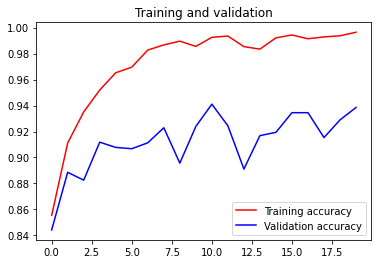

<Figure size 432x288 with 0 Axes>

In [ ]:
# display the performance of the model graphically
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.plot(epochs, loss, 'g', label='Training loss')
#plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
score = model.evaluate(val_generator)
print(score)

63/63 [==============================] - 19s 297ms/step - loss: 0.2441 - accuracy: 0.9379
[0.24411308765411377, 0.937903642654419]


In [ ]:
import numpy as np
probabilities = model.predict_generator(val_generator)
y_true = val_generator.classes
y_pred = np.argmax(probabilities, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
print(y_pred,y_true)

[2 4 0 ... 2 0 2] [0 0 0 ... 4 4 4]


In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
font = {
'family': 'Times New Roman',
'size': 12
}
plt.rc('font', **font)
mat = confusion_matrix(y_true, y_pred)
print(mat)
class_labels = list(val_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

[[338 235 239]
 [252 201 163]
 [230 196 159]]
              precision    recall  f1-score   support

           0       0.41      0.42      0.41       812
           1       0.32      0.33      0.32       616
           2       0.28      0.27      0.28       585

    accuracy                           0.35      2013
   macro avg       0.34      0.34      0.34      2013
weighted avg       0.35      0.35      0.35      2013



In [ ]:
nb_row = 4
nb_col = 6
nb = 1
plt.figure(figsize=(25, 15))
for row in df.itertuples():
    if nb > nb_col * nb_row:
        break
    plt.subplot(nb_row, nb_col, nb)
    plt.imshow(cv2.cvtColor(imagePreprocessing(openImage(row), normalize=False), cv2.COLOR_BGR2RGB))
    plt.title('Diagnosed {}'.format(row.diagnosis))
    nb += 1
plt.show()

In [ ]:
!zip !zip -r preprocessed{.zip,}